# Imports:

In [ ]:
from google.colab import drive

drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
! pip install pygam
! pip install catboost

     |████████████████████████████████| 1.8MB 2.8MB/s 
     |████████████████████████████████| 64.8MB 59kB/s 


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
from pygam import LinearGAM

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA 
from sklearn.ensemble import RandomForestRegressor

from catboost import Pool
from catboost import CatBoostRegressor

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
np.random.seed(42)



---



# Validation strategy:


As were founded in EDA train data can be splitted on train and validation parts in a same way as train and test were splitted: <br>
1. Only years > treshold year are being splitted.
2. Last year should exist only in validation part.

In [ ]:
train = pd.read_csv('/gdrive/My Drive/Colab Notebooks/McKinsey_prohack_2020_a/Data/train.csv')
test = pd.read_csv('/gdrive/My Drive/Colab Notebooks/McKinsey_prohack_2020_a/Data/test.csv')

In [ ]:
train_test_spit_trsh_year = test['galactic year'].min()
print(f'Train treshold year: {train_test_spit_trsh_year}')

Train treshold year: 1007012


In [ ]:
def generate_train_test_split(train_df, train_test_spit_trsh_year, return_all_columns=False, stratify=True, test_size=0.25):

  '''
  Function returns local train and test sets splitted in the same way as 
  original data were splitted.
  '''

  last_year_part = train_df[train_df['galactic year'] == train_df['galactic year'].max()]
  part_to_split = train_df[(train_df['galactic year'] >= train_test_spit_trsh_year) &
                        (train_df['galactic year'] != train_df['galactic year'].max())]
  static_part = train_df[train_df['galactic year'] < train_test_spit_trsh_year]

  if stratify:
    tr, tst, _, _ = train_test_split(part_to_split, part_to_split.y,
                                    stratify=part_to_split.galaxy,
                                              test_size=test_size) 
  else:
    tr, tst, _, _ = train_test_split(part_to_split, part_to_split.y,
                                              test_size=test_size) 

  
  tr_new = pd.concat([static_part, tr])[['galaxy', 'galactic year', 'y']]
  tst_new = pd.concat([tst, last_year_part])[['galaxy', 'galactic year', 'y']]
  if return_all_columns:
    tr_new = pd.concat([static_part, tr])
    tst_new = pd.concat([tst, last_year_part])

  return tr_new, tst_new

In [ ]:
train_local, test_local = generate_train_test_split(train, train_test_spit_trsh_year=train_test_spit_trsh_year)

Lets inspect split visually:

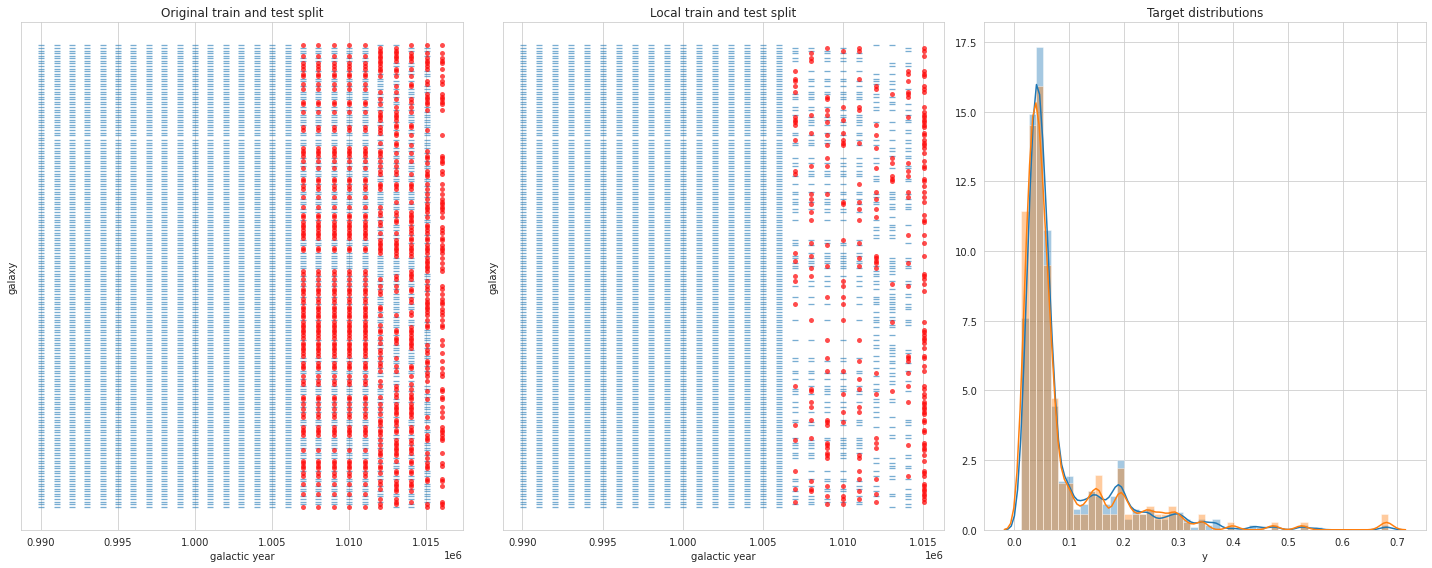

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
sns.set_style("whitegrid")

sns.scatterplot(train['galactic year'], train.galaxy, marker='_', linewidth=1.3, alpha=0.6, s=30, ax=ax[0])
sns.scatterplot(test['galactic year'], test.galaxy, color='r', linewidth=0, alpha=0.7, s=25, ax=ax[0])

sns.scatterplot(train_local['galactic year'], train_local.galaxy, marker='_', linewidth=1.3, alpha=0.6, s=30, ax=ax[1])
sns.scatterplot(test_local['galactic year'], test_local.galaxy, color='r', linewidth=0, alpha=0.7, s=25, ax=ax[1])

sns.distplot(train[train['galactic year'] >= train_test_spit_trsh_year].y, label='Test part', ax=ax[2])
sns.distplot(test_local.y, label='Local test part', ax=ax[2])

ax[0].set_yticklabels([])
ax[0].set_yticks([]) 
ax[1].set_yticklabels([])
ax[1].set_yticks([]) 

ax[0].set_title('Original train and test split')
ax[1].set_title('Local train and test split')
ax[2].set_title('Target distributions')

fig.tight_layout()

Such local train-test split represents original data split and being used further for local testing and validation.



---



# Naive baseline model:

First I define simple baseline model. Here target predicted as last presented target before predicted year.

In [ ]:
train_test_spit_trsh_year = test['galactic year'].min()
print(f'Train treshold year: {train_test_spit_trsh_year}')

Train treshold year: 1007012


In [ ]:
def cv_loop_baseline(train_df, n_loops=5):

  '''
  Function returnes RMSE scores after `n_loops` of train and predictions.
  '''

  loop_scores = []
  for _ in range(n_loops):
    tr_new, tst_new = generate_train_test_split(train_df,
                                                return_all_columns=False,
                                                train_test_spit_trsh_year=train_test_spit_trsh_year)
    
    predictions = []
    for idx in tst_new.index:
      year = tst_new.loc[idx, 'galactic year']
      galaxy = tst_new.loc[idx, 'galaxy']
      prev_year = tr_new[(tr_new['galaxy'] == galaxy) &
                            (tr_new['galactic year'] < year)]['galactic year'].max() 
      prd = tr_new[(tr_new['galaxy'] == galaxy) & 
                    (tr_new['galactic year'] == prev_year)].y.values[0]

      predictions.append(prd)

    score = mean_squared_error(tst_new.y, predictions)**0.5
    loop_scores.append(score)
    
  loop_scores = np.array(loop_scores)

  return loop_scores

In [ ]:
scores = cv_loop_baseline(train)

print(f'Baseline RMSE: {scores.mean():.4f}+-{scores.std():.4f}.')

Baseline RMSE: 0.0220+-0.0014.




---



# Years based model:

As were founded in EDA section, target variable are likely can be nicely predicted just by `galactic year` feature. Following model performs such predictions.

First lets plot year and target graph for different galaxies in order to get the idea about which model can fit such data best. 

In [ ]:
def get_galaxy_samples(train_df, n_galaxys, min_years=15):

  '''
  Function return n_galaxys random samples with 
  amount of galactic years not less then min_years.
  '''

  galaxy_sample = set()
  while len(galaxy_sample) < n_galaxys:
    galaxy = train_df.galaxy.sample(1).values[0]
    if len(train_df[train_df['galaxy'] == galaxy]['galactic year']) > min_years:
      galaxy_sample.add(galaxy)

  galaxy_sample = [glxy for glxy in galaxy_sample]

  return galaxy_sample

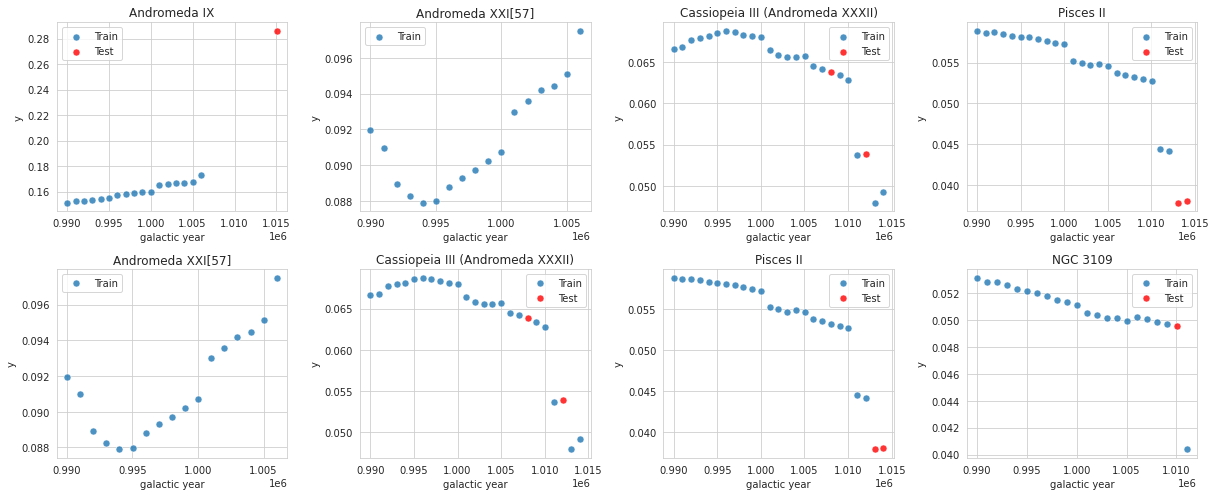

In [ ]:
galaxy_samples = get_galaxy_samples(train, 8)

fig, ax = plt.subplots(2, 4, figsize=(17, 7))

for i in range(2):
  for j in range(4):
    galaxy = galaxy_samples[i+j]

    sns.scatterplot(train_local[train_local['galaxy'] == galaxy]['galactic year'],
                    train_local[train_local['galaxy'] == galaxy].y,
                    s=50, alpha=0.8, label='Train', ax=ax[i][j])
    sns.scatterplot(test_local[test_local['galaxy'] == galaxy]['galactic year'],
                    test_local[test_local['galaxy'] == galaxy].y,
                    s=50, color='r', alpha=0.8, label='Test', ax=ax[i][j])

    ax[i][j].set_title(galaxy)

fig.tight_layout()

As one can see for most of galaxies bilinear model can fits fine, but some (like Andromeda XXI) has more complex dependency, so it is better to use more flexible model. Thus I decided to use Linear GAM model with splines:

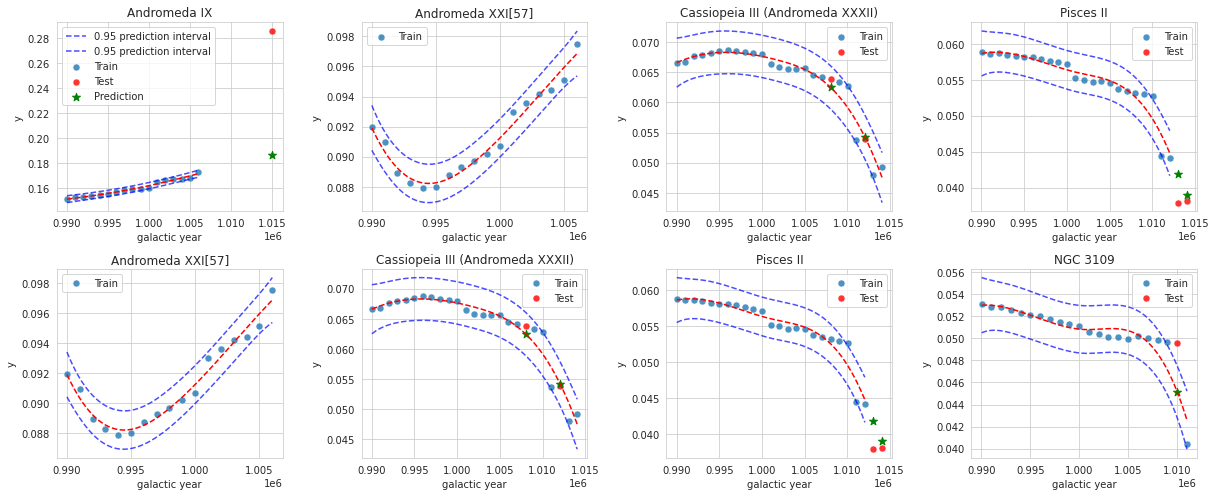

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(17, 7))

for i in range(2):
  for j in range(4):
    galaxy = galaxy_samples[i+j]

    sns.scatterplot(train_local[train_local['galaxy'] == galaxy]['galactic year'],
                    train_local[train_local['galaxy'] == galaxy].y,
                    s=50, alpha=0.8, label='Train', ax=ax[i][j])
    sns.scatterplot(test_local[test_local['galaxy'] == galaxy]['galactic year'],
                    test_local[test_local['galaxy'] == galaxy].y,
                    s=50, color='r', alpha=0.8, label='Test', ax=ax[i][j])
    
    train_subset = train_local[train_local['galaxy'] == galaxy]
    test_subset = test_local[test_local['galaxy'] == galaxy]
    X_train = train_subset['galactic year'].values.reshape(-1, 1)
    X_test = test_subset['galactic year'].values.reshape(-1, 1)
    y_train = train_subset.y
    y_test = test_subset.y

    gam = LinearGAM(n_splines=5).gridsearch(X_train, y_train, progress=False)
    XX = gam.generate_X_grid(term=0, n=500)

    ax[i][j].plot(XX, gam.predict(XX), 'r--')
    ax[i][j].plot(XX, gam.prediction_intervals(XX, width=.95),
                  color='b', alpha=0.7, ls='--', label='0.95 prediction interval')

    ax[i][j].set_title(galaxy)

    try:
      ax[i][j].scatter(X_test, gam.predict(X_test),
                       facecolor='green', marker='*', s=70, label='Prediction')
    except ValueError:
      continue

ax[0][0].legend()
fig.tight_layout()

So it seems that LinearGAM model can fit the data and perform reasonable predictions. <br>
Also it is likely that model can be improved if we add data from simmilar galaxys for train data. <br>
As for now we focusing only on `galactic year` feature lets define galaxys similarity by RMSE between target values `y` for same set of years for different galaxys:

In [ ]:
def find_similar_galaxys(df, galaxy, treshold):

  '''
  Function return list of galaxy similar to input galaxy including given galaxy.
  Similarity measures by MSE between `y` for same set of years and filtred by treshold.
  '''

  similar_galaxys = []

  df_current_subset = df[df['galaxy'] == galaxy]
  current_years = df_current_subset['galactic year']
  rest_galaxys = list(df.galaxy.unique())

  for glxy in rest_galaxys:
    subset_to_compare = df[df['galaxy'] == glxy]
    subset_years = subset_to_compare['galactic year']
    common_years = set(current_years).intersection(set(subset_years))
    common_years = [year for year in common_years]

    base_y = df_current_subset[df_current_subset['galactic year'].isin(common_years)].y
    to_compare_y = subset_to_compare[subset_to_compare['galactic year'].isin(common_years)].y

    metric_similarity = mean_squared_error(base_y, to_compare_y)

    if metric_similarity < treshold:
      similar_galaxys.append(glxy)

  return similar_galaxys

Now lets check several similar galaxys:

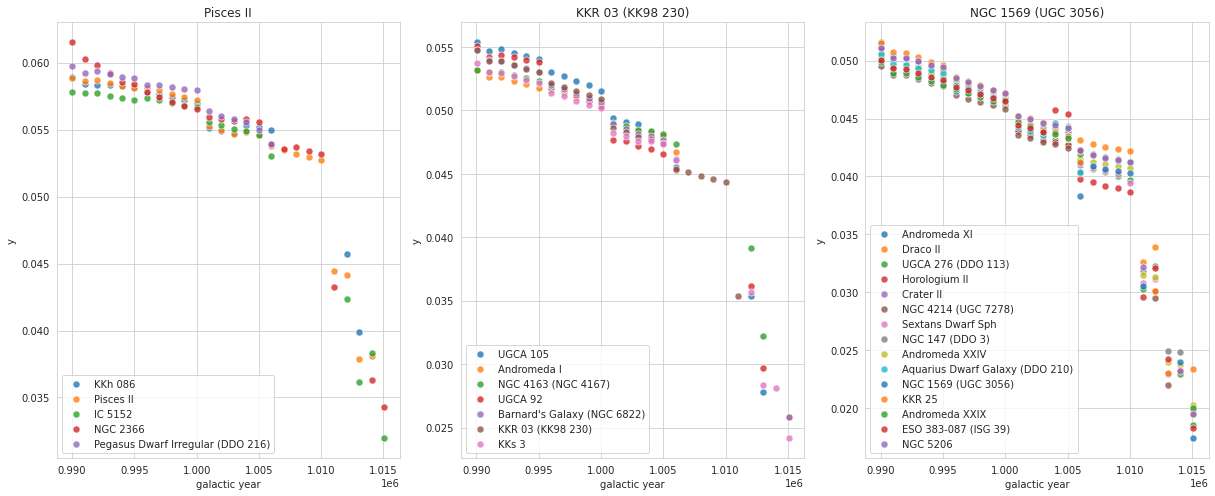

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(17, 7))

galaxy_samples = get_galaxy_samples(train, 3)

for i in range(3):
  
  galaxy = galaxy_samples[i]
  similar_galaxys = find_similar_galaxys(train_local, galaxy, treshold=1e-6)

  for similar_galaxy in similar_galaxys:
    sns.scatterplot(train[train['galaxy'] == similar_galaxy]['galactic year'],
                    train[train['galaxy'] == similar_galaxy].y,
                    s=50, alpha=0.8, label=similar_galaxy, ax=ax[i])

  ax[i].set_title(galaxy)
  ax[i].legend(loc='lower left')

fig.tight_layout()

It is clear that such approach can improve predictions for galaxys with similar ones. <br>
Finally we obtain model with follwing parameters:
1. Number of splines in LinearGAM model.
2. Treshold of similarity for neighboring galaxys.<br>


For now we can find best parameters with grid search and CV-loop based on validation strategy defined above. 


In [ ]:
def get_extended_gam_predictions(train_df, test_df, similarity_treshold, n_splines):

  '''
  Function train LinearGAM model with `n_splines` for data with data form simmilar galaxys.
  Similarity regulated by `similatity_treshold`, if 0 then only one galaxy data used.
  Function returns prediction for galaxy-year pair.
  '''
  result = []

  for idx in test_df.index:
    galaxy = test_df.loc[idx, 'galaxy']

    similar_galaxys = find_similar_galaxys(train_df, galaxy, similarity_treshold)
    similar_galaxys.append(galaxy)

    train_subset = train_df.query('galaxy in @similar_galaxys')

    X_train = train_subset['galactic year'].values.reshape(-1, 1)
    y_train = train_subset.y
    X_predict = test_df.loc[idx, 'galactic year']

    gam = LinearGAM(n_splines=n_splines, verbose=False).gridsearch(X_train, y_train, progress=False)
    prediction = gam.predict(X_predict).clip(0)
    result.append(prediction)

  return np.array(result)

In [ ]:
def cv_loop(train_df, treshold, n_splines, n_loops=5):

  '''
  Function returnes scores from `n_loops` of train and predictions.
  '''
  
  loop_scores = []
  for _ in range(n_loops):
    tr_new, tst_new = generate_train_test_split(train, train_test_spit_trsh_year=train_test_spit_trsh_year)
    gam_pred = get_extended_gam_predictions(tr_new, tst_new, treshold, n_splines)
    score = mean_squared_error(tst_new.y, gam_pred)**0.5
    loop_scores.append(score)
  loop_scores = np.array(loop_scores)

  return loop_scores

In [ ]:
def grid_search(train_df, n_splines, tresholds, n_loops=5, verbose=True):

  best_params = {'n_splines': 0,
                'treshold': 0}
  best_score = [1e6, 1e6] # mean value and std

  for n in n_splines:
    if verbose:
      print(f'n splines :{n}')
    for tr in tresholds:
      cv_loop_csores = cv_loop(train_df, tr, n, n_loops)
      if cv_loop_csores.mean() < best_score[0]:
        best_score[0], best_score[1] = cv_loop_csores.mean(), cv_loop_csores.std()
        best_params['n_splines'] = n
        best_params['treshold'] = tr

      if verbose:
        print(f'  treshold: {tr}')
        print(f'  mean RMSE over {n_loops} loops: {cv_loop_csores.mean():.4f} +- {cv_loop_csores.std():.4f}')
    if verbose:    
      print('--------------\n')   

  if verbose:
    print('----Grid search finished-----')
    print('Best parameters:')
    n_spl = best_params['n_splines']
    trshld = best_params['treshold']
    print(f'  n splines {n_spl}')
    print(f'  treshold {trshld}')
    print('Best score:')
    print(f'  {best_score[0]:.4f}+-{best_score[1]:.4f}.')

  return best_params, best_score

In [ ]:
n_splines = [4, 5, 6]
tresholds = [0, 1e-7, 1e-5, 1e-4, 1e-3]

best_params, best_score = grid_search(train, n_splines, tresholds, n_loops=3, verbose=True)

n splines :4
  treshold: 0
  mean RMSE over 3 loops: 0.0183 +- 0.0004
  treshold: 1e-07
  mean RMSE over 3 loops: 0.0195 +- 0.0005
  treshold: 1e-05
  mean RMSE over 3 loops: 0.0183 +- 0.0004
  treshold: 0.0001
  mean RMSE over 3 loops: 0.0176 +- 0.0014
  treshold: 0.001
  mean RMSE over 3 loops: 0.0219 +- 0.0009
--------------

n splines :5
  treshold: 0
  mean RMSE over 3 loops: 0.0180 +- 0.0009
  treshold: 1e-07
  mean RMSE over 3 loops: 0.0173 +- 0.0003
  treshold: 1e-05
  mean RMSE over 3 loops: 0.0167 +- 0.0009
  treshold: 0.0001
  mean RMSE over 3 loops: 0.0160 +- 0.0005
  treshold: 0.001
  mean RMSE over 3 loops: 0.0209 +- 0.0006
--------------

n splines :6
  treshold: 0
  mean RMSE over 3 loops: 0.0184 +- 0.0005
  treshold: 1e-07
  mean RMSE over 3 loops: 0.0185 +- 0.0009
  treshold: 1e-05
  mean RMSE over 3 loops: 0.0189 +- 0.0008
  treshold: 0.0001
  mean RMSE over 3 loops: 0.0179 +- 0.0007
  treshold: 0.001
  mean RMSE over 3 loops: 0.0213 +- 0.0007
--------------

----Gri

Such model overperformes baseline model.

Final prediction for best params:

In [ ]:
gam_prediction = get_extended_gam_predictions(train, test, similarity_treshold=0.0001, n_splines=5)

Saving predictions:

In [ ]:
gam_prediction_df = pd.DataFrame(gam_prediction, columns=['Index_gam_prediction'])
gam_prediction_df.to_csv('/gdrive/My Drive/Colab Notebooks/Competitions/ProHack/Predictions/predictions_gam.csv', index=False)



---



# CatBoost model:

In [ ]:
train_subset_filled = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Competitions/ProHack/Datasets/train_subset_filled_fgen.csv')
test_subset_filled = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Competitions/ProHack/Datasets/test_subset_filled_fgen.csv')

In [ ]:
test_subset_filled.head()

,galactic year,galaxy,pc_0,pc_1,pc_2,pc_3,pc_4,y,2_knn,3_knn,5_knn,prev_y,trend,knn_std
0,17,KK98 77,1.242269,-0.634903,0.168701,-0.640458,-0.060072,NaN,0.046302,0.046978,0.046552,0.041937,0.001645,0.000342
1,17,Reticulum III,4.934285,0.084577,0.888820,-0.350445,-0.246174,NaN,0.040322,0.039460,0.039467,0.038980,0.002595,0.000496
2,18,Reticulum III,4.429655,-0.002416,0.913859,-0.317154,-0.374316,NaN,0.040228,0.039347,0.039184,0.038980,0.002595,0.000562
3,17,Segue 1,2.377234,-0.194623,0.607038,0.259643,0.062755,NaN,0.049327,0.046925,0.046647,0.038750,0.002449,0.001473
4,23,Virgo I,3.645658,-0.178772,0.856057,-0.572592,-0.281514,NaN,0.026192,0.025149,0.025649,0.029937,-0.000101,0.000522


In [ ]:
train_subset = train[good_features + ['y']].copy()
test_subset = test[good_features].copy()

In [ ]:
def cv_loop_cb(train_df, model, n_loops=5):

  '''
  Function returnes scores from `n_loops` of train and predictions.
  '''

  cat_features = ['galaxy']

  loop_scores = []
  n_iters = []
  for _ in range(n_loops):
    tr_new, tst_new = generate_train_test_split(train_df,
                                                return_all_columns=True,
                                                train_test_spit_trsh_year=train_test_spit_trsh_year)

    fs = list(tr_new.columns)
    if 'index' in fs:
      fs.remove('index')
    fs.remove('y')

    X_tr = tr_new[fs]
    y_tr = tr_new.y

    X_test = tst_new[fs]
    y_test = tst_new.y

    pool_train = Pool(data=X_tr, label=y_tr, cat_features=cat_features)
    pool_validate = Pool(data=X_test, label=y_test, cat_features=cat_features)
    
    model.fit(pool_train, eval_set=pool_validate)
    score = model.best_score_['validation']['RMSE']
    best_iter = model.best_iteration_

    loop_scores.append(score)
    n_iters.append(best_iter)

  loop_scores = np.array(loop_scores)
  n_iters = np.array(n_iters)

  return loop_scores, n_iters

Define model:

In [ ]:
model = CatBoostRegressor(iterations=6000,
                          random_seed=42,
                          loss_function='RMSE',
                          eval_metric='RMSE',
                          learning_rate=0.03,
                          od_type='Iter',
                          leaf_estimation_iterations=10,
                          max_ctr_complexity=10,
                          depth=5,
                          od_wait=30,
                          verbose=0)

Perform CV-loop to define number of iterations for fixed learning rate:

In [ ]:
scores, iters = cv_loop_cb(train_subset_filled, model)

print(f'CV loop scores: {scores.mean():.4f}+-{scores.std():.4f}')
print(f'CV loop best iters: {iters.mean():.0f}+-{iters.std():.0f}')

CV loop scores: 0.0186+-0.0006
CV loop best iters: 221+-63


CatBoost model with preprocessed dataset overperforms baseline model, now lets retrain in on whole dataset and predict for test set:

In [ ]:
model = CatBoostRegressor(iterations=220,
                          random_seed=42,
                          loss_function='RMSE',
                          eval_metric='RMSE',
                          learning_rate=0.03,
                          leaf_estimation_iterations=10,
                          max_ctr_complexity=10,
                          depth=5,
                          verbose=100)

In [ ]:
fs = list(test_subset_filled.columns)
fs.remove('y')

X_tr = train_subset_filled[fs]
y_tr = train_subset_filled.y

X_prd = test_subset_filled[fs]

cat_features = ['galaxy']

pool_train = Pool(data=X_tr, label=y_tr, cat_features=cat_features)
pool_predict = Pool(data=X_prd, cat_features=cat_features)

In [ ]:
model.fit(pool_train)
prediction = model.predict(pool_predict)

0:	learn: 0.0617010	total: 5.38ms	remaining: 1.18s
100:	learn: 0.0082304	total: 545ms	remaining: 642ms
200:	learn: 0.0048313	total: 1.06s	remaining: 100ms
219:	learn: 0.0045727	total: 1.16s	remaining: 0us


In [ ]:
cat_boost_model_prediction_df = pd.DataFrame(prediction, columns=['CatBoost_prediction'])
cat_boost_model_prediction_df.to_csv('/gdrive/My Drive/Colab Notebooks/Competitions/ProHack/Predictions/predictions_catboost.csv', index=False)



---



# Emsemble:

Here I perform ensembling of 2 models using meta holdout scheme with OOF meta-features, strategy is follows: <br>

1. Split train data into K folds. Iterate though each fold: retrain LinearGAM  and CatBoost models on all folds except current fold, get prediction of both models for the current fold (train_meta).
2. Fit models to whole train data and predict for test data (test_meta).
3. Split train_meta into two parts: train_metaA and train_metaB. Fit a meta-model to train_metaA while validating it on train_metaB.
When the meta-model is validated, fit it to train_meta and predict for test_meta.



In [ ]:
train_gam = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Competitions/ProHack/Datasets/train.csv')
test_gam = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Competitions/ProHack/Datasets/test.csv')

In [ ]:
train_cb = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Competitions/ProHack/Datasets/train_extended_fg.csv')
test_cb = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Competitions/ProHack/Datasets/test_extended_fg.csv')

In [ ]:
df = pd.concat([train_gam, test_gam]).reset_index()

le = LabelEncoder()
df['galactic year'] = le.fit_transform(df['galactic year'])

df.drop('index', axis=1, inplace=True)
N = train_gam.shape[0]
train_gam = df.loc[:N-1]
test_gam = df.loc[N:]

train_test_spit_trsh_year = test['galactic year'].min()
print(f'Train treshold year: {train_test_spit_trsh_year}')

Train treshold year: 17


In [ ]:
def get_cb_prediction(train_df, test_df):

  '''
  Returns CatBoost model prediction.
  '''

  model = CatBoostRegressor(iterations=220,
                          random_seed=42,
                          loss_function='RMSE',
                          eval_metric='RMSE',
                          learning_rate=0.03,
                          leaf_estimation_iterations=10,
                          max_ctr_complexity=10,
                          depth=5,
                          verbose=0)
  
  fs = list(train_df.columns)
  fs.remove('y')
  
  X_tr = train_df[fs]
  y_tr = train_df.y

  X_prd = test_df[fs]

  cat_features = ['galaxy']

  pool_train = Pool(data=X_tr, label=y_tr, cat_features=cat_features)
  pool_predict = Pool(data=X_prd, cat_features=cat_features)

  model.fit(pool_train)
  prediction = model.predict(pool_predict)

  return prediction

In [ ]:
def predict_oof_train_meta(train_gam, train_cb, train_test_spit_trsh_year):

  '''
  Function perform out of fold prediction for 5 folds 
  with LinearGAM model and CatBoost models.
  Returns train_meta features.
  '''

  static_part_gam = train_gam[train_gam['galactic year'] < train_test_spit_trsh_year].copy()
  part_to_split_gam = train_gam[(train_gam['galactic year'] >= train_test_spit_trsh_year)].copy()
  static_part_gam = static_part.reset_index()
  part_to_split_gam = part_to_split.reset_index()

  static_part_cb = train_cb[train_cb['galactic year'] < train_test_spit_trsh_year].copy()
  part_to_split_cb = train_cb[(train_cb['galactic year'] >= train_test_spit_trsh_year)].copy()
  static_part_cb = static_part_cb.reset_index()
  part_to_split_cb = part_to_split_cb.reset_index()

  kf = KFold(n_splits=5, random_state=42, shuffle=True)
  kf.get_n_splits(part_to_split_gam)

  predictions = pd.DataFrame(np.zeros(shape=(part_to_split_gam.shape[0], 5)),
                            columns=['galaxy', 'galactic year', 'prd_1', 'prd_2', 'y'])
  
  k_1, k_2 = 0, 0
  for tr_idx, tst_idx in kf.split(part_to_split_gam):
    tr_pts_gam, tst_pts_gam = part_to_split_gam.loc[tr_idx], part_to_split_gam.loc[tst_idx]
    tr_pts_cb, tst_pts_cb = part_to_split_cb.loc[tr_idx], part_to_split_cb.loc[tst_idx]

    tr_new_gam = pd.concat([static_part_gam, tr_pts_gam])[['galaxy', 'galactic year', 'y']]
    tst_new_gam = tst_pts_gam[['galaxy', 'galactic year', 'y']]
    tr_new_cb = pd.concat([static_part_cb, tr_pts_cb])

    pred_1 = get_extended_gam_predictions(tr_new_gam, tst_new_gam, similarity_treshold=0.0001, n_splines=5)
    pred_2 = get_cb_prediction(tr_new_cb, tst_pts_cb)
    
    k_2 += len(pred_1) 
    predictions.loc[k_1:k_2-1, 'galaxy'] = tst_new_gam['galaxy'].values
    predictions.loc[k_1:k_2-1, 'galactic year'] = tst_new_gam['galactic year'].values
    predictions.loc[k_1:k_2-1, 'y'] = tst_new_gam['y'].values
    predictions.loc[k_1:k_2-1, 'prd_1'] = pred_1
    predictions.loc[k_1:k_2-1, 'prd_2'] = pred_2
    k_1 += len(pred_1)

  return predictions

In [ ]:
train_meta = predict_oof_train_meta(train_gam, train_cb, train_test_spit_trsh_year)

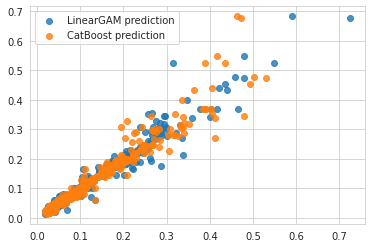

In [ ]:
plt.scatter(train_meta['prd_1'], train_meta['y'], alpha=0.8, label='LinearGAM prediction')
plt.scatter(train_meta['prd_2'], train_meta['y'], alpha=0.8, label='CatBoost prediction')
plt.legend()

As one can see models provide diversed predicitons and can be used for ensembling.

Here I decide to use simple weighted averaging as meta-model, and define weights just with brut force:

In [ ]:
fs = list(train_meta.columns)
fs.remove('y')

X_meta = train_meta[fs]
y_meta = train_meta.y

# RMSE for meta-model
kf = KFold(n_splits=5, random_state=42, shuffle=True)
kf.get_n_splits(train_meta)

result = dict()
for a in np.linspace(0, 1, 20):
  scores = []
  for tr_idx, tst_idx in kf.split(train_meta):
      X_tr, X_tst = X_meta.loc[tr_idx], X_meta.loc[tst_idx]
      y_tr, y_tst = y_meta.loc[tr_idx], y_meta.loc[tst_idx]

      meta_prd = a * X_tst['prd_1'] + (1 - a) * X_tst['prd_2']
      score = mean_squared_error(y_tst, meta_prd)**0.5

      scores.append(score)
  scores = np.array(scores)
  result[a] = (scores.mean(), scores.std())

Optimal a: 0.63


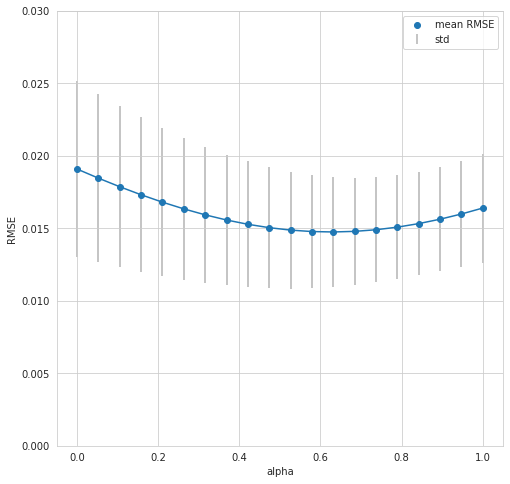

In [ ]:
mean_score = []
std = []
a = []
for key in result.keys():
  mean_score.append(result[key][0])
  std.append(result[key][1])
  a.append(key)

opt_a = a[np.array(mean_score).argmin()]
print(f'Optimal a: {opt_a:.2f}')


fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(a, mean_score)
ax.scatter(a, mean_score, label='mean RMSE')
ax.errorbar(a, mean_score, yerr=std,
    ecolor='gray', alpha=0.6, fmt=' ', zorder=-1, label='std')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
ax.set_ylim([0, 0.03])
ax.legend()

As one can see weighted averaging preformes better than sepatrate models: <br>
* Baseline model mean RMSE - 0.022
* LinearGAM model mean RMSE - 0.016
* CatBoost model mean RMSE - 0.018
* Weighted average mean RMSE - 0.015 


In [ ]:
train_meta.to_csv('/gdrive/My Drive/Colab Notebooks/Competitions/ProHack/Predictions/predictions_meta.csv', index=False)

Then it is possible to perform final prediction:

In [ ]:
test_meta = pd.DataFrame(np.zeros(shape=(test_gam.shape[0], 5)),
                            columns=['galaxy', 'galactic year', 'prd_1', 'prd_2', 'final_prediction'])

In [ ]:
pred_1_gam = get_extended_gam_predictions(train_gam, test_gam, similarity_treshold=0.0001, n_splines=5)
pred_2_cb = get_cb_prediction(train_cb, test_cb)

test_meta['galaxy'] = test_gam['galaxy'].values
test_meta['galactic year'] = test_gam['galactic year'].values
test_meta['prd_1'] = pred_1_gam
test_meta['prd_2'] = pred_2_cb

a = opt_a # 0.63
test_meta['final_prediction'] = a * test_meta['prd_1'] + (1 - a) * test_meta['prd_2']

In [ ]:
test_meta.to_csv('/gdrive/My Drive/Colab Notebooks/Competitions/ProHack/Predictions/predictions_test_meta.csv', index=False)